In [1]:
import os
import sys
from contextlib import nullcontext
import cv2
from tqdm import tqdm
import torch
from PIL import Image
from einops import repeat
from pytorch_lightning import seed_everything
from torch import autocast

from common import parser, OmegaConf, load_model_from_config, latent_to_image, \
    load_img, make_dataset_txt, data_to_dict

lldm_dir = os.path.abspath('./')
sys.path.append(lldm_dir)
from ldm.models.diffusion.ddim import DDIMSampler

In [2]:
from safetensors.torch import load_model
from ldm.util import instantiate_from_config

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys: pass")
    #         print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys: pass")
    model.eval()
    return model

def load_model_from_config_safe(config, safetensors, verbose=False):
    model = instantiate_from_config(config.model)
    m, u = load_model(model, safetensors, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys: pass")
#             print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys: pass")
    model.eval()
    return model

In [3]:
# prepare
config = OmegaConf.load('configs/stable-diffusion/v1-inference.yaml')
model = load_model_from_config(config, 'models/ldm/stable-diffusion-v1/model.ckpt')
# model = load_model_from_config_safe(config, 'models/ldm/stable-diffusion-v1/xxmix9realistic_v40.safetensors')
device = torch.device("cuda")
model = model.to(device)
sampler = DDIMSampler(model)
seed_everything(42)
model.cond_stage_model = model.cond_stage_model.to(device)
precision_scope = autocast

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.18.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.bias', 'vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.layer_norm1.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vi

In [4]:
import numpy as np
def get_mask_dilate(mask_path, dilate_args=None):
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = img_mask / 255
    img_mask[img_mask !=0] = 1
    if dilate_args is not None:
        kernel = np.ones((dilate_args[0], dilate_args[0]), dtype=np.uint8)
        img_mask = cv2.dilate(img_mask, kernel, dilate_args[1])
    img_mask = cv2.resize(img_mask, (64, 64), interpolation=cv2.INTER_LANCZOS4)
    img_mask[img_mask > 0.5] = 1
    img_mask[img_mask !=1] = 0
    img_mask = torch.Tensor(img_mask).unsqueeze(0).unsqueeze(0).cuda()
    return img_mask

In [5]:
DDIM_STEPS=50
root_dir = 'demo/' # specify the directory where input images and their masks,text prompts are stored
sampler.make_schedule(ddim_num_steps=DDIM_STEPS, ddim_eta=0.0, verbose=False)

In [7]:
################################# object replace ############################################
# =============Specify the layers where Progressive Feature Blending (PFB) is applied.=============
fusion_layers = {
    "encoder": [7, 8, 9, 10, 11],
    "middle": True,
    "decoder": [12, 13, 14, 15, 16, 17]
}
# =============Specify the layers where Attention Masking (AM) is applied.=============
# For object replacement, we can set AM to False for convenience;
# when setting AM to True, you need to specify the word position and mask. For details, see Background Replacement
attn_layers = {
    "encoder": [],
    "decoder": [],
}
# We set the starting time for the sampling process to t=1000 and end at t=0
# ============================  specifiy hyper parameters  ==================================
t_combine = 0  # We apply PFB for timesteps between [1000, t_combine]
# We apply latent-level blending for timesteps between [1000, 1000*self_replace_step],
self_replace_step = 0.5
#  You can adjust 'self_replace_step' as needed to achieve better results.
masked_attn = False  # Set to False for object replace for convenience
init_rand = True
# If init_rand = True, the sampling process starts from random noise, enabling diverse results;
# If init_rand = True, RATIO needs to be set to 1.
# For object attribute editing, init_rand needs to be set to False.
# If init_rand = False, sample process start from the result of ddim encoding with ratio=RATIO
RATIO = 1  # Encoding ratio for ddim encoding
NUM_SAMPLES = 1 # with init_rand = True, it is possible to sample multiple times and select the preferred result
# ============================  starting sampling  ==================================
prompts_dict = data_to_dict(make_dataset_txt(
    'demo/orig_prompt.txt'))  # load the original text descriptions
edit_prompts = {
    0: "a duck",
    1: "a robot",
    2: "white straight hair",
    3: "a rabbit",
    4: "a girl with blonde short hair, white sweater",
    5: "a tiger",
    7: "a pencil drawing of a river",
    9: "an owl",
    10: "a monster cake",     # set RATIO=0.8, init_rand = False
    12: "red hat",
    13: "river in Hayao Miyazaki style",
    14: "a mushroom",
    15: "a few white roses",
    16: "blue leather jacket", # set RATIO=0.8, init_rand = False
    18: "two crochet birds",  # set RATIO=0.8, init_rand=False
        # you can adjust RATIO as needed to achieve better results.
    19: "a teddy bear",
}

# Specify the target image
# name_list = [0,1,2,3]
name = 3

# Specify the output dir
out_dir = os.path.join('results', 'ours-object')
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    with precision_scope(device.type):
        with model.ema_scope():
            name = str(name)
            # load image and mask
            img_path = os.path.join(root_dir, 'img_dir/%s.png' % name)
            tgt_image = repeat(load_img(img_path, 512, 512).cuda(), '1 ... -> b ...', b=1)
            prompt = prompts_dict[name]
            edit_prompt = edit_prompts[int(name)]
            print(prompt)
            print(edit_prompt)
            tgt_mask = get_mask_dilate(
                os.path.join(root_dir, 'masks/%s.png' % name))
            # define model_kwargs
            model_kwargs = {}
            model_kwargs['fusion_layers'] = fusion_layers
            model_kwargs["t_combine"] = t_combine
            model_kwargs["tgt_mask"] = tgt_mask
            model_kwargs["attn_mask"] = {
                'attn_mask': tgt_mask.clone(),
                'words': [[], []]
            } if masked_attn else None
            model_kwargs["attn_layers"] = attn_layers
            model_kwargs["self_replace_step"] = self_replace_step
            # get text conditions
            uc = model.get_learned_conditioning([""])
            # for xxmix9realistic_v40 model, you can use negetive prompting
            # negetive_prompt = 'easynegative,ng_deepnegative_v1_75t,(worst quality:2),(low quality:2),(normal quality:2),lowres,bad anatomy,bad hands,normal quality,((monochrome)),((grayscale)),((watermark)),'
            # uc = model.get_learned_conditioning([negetive_prompt])
            src_cond = model.get_learned_conditioning([prompt])
            tgt_cond = model.get_learned_conditioning([edit_prompt])
            # get noisy images
            t_enc = int(DDIM_STEPS * RATIO)
            ref_latent = model.get_first_stage_encoding(
                model.encode_first_stage(tgt_image))
            ref_latents = sampler.ddim_loop(
                ref_latent, src_cond, t_enc)

            def corrector_fn(x, index):
                if index / DDIM_STEPS > model_kwargs['self_replace_step']:
                    x = x * tgt_mask + \
                        (1 - tgt_mask) * ref_latents[index]
                return x

            # sampling
            
            # It is possible to sample multiple times and select the preferred result.
            for ii in range(NUM_SAMPLES):
                if init_rand:
#                     init_latent = torch.randn(ref_latents[-1].shape).cuda()
#                     init_latent = torch.load('data/rand_inits/%d.pt' % ii).cuda()
#                     to reproduce the results in Figure 7 of the manuscript,run the following line
                    init_latent = torch.load('data/samples_in_paper/%s.pt' % name).cuda()
                else:
                    init_latent = ref_latents[-1].clone()

                recover_latent = sampler.ddim_replace_object(init_latent, ref_latents, src_cond, tgt_cond, t_enc,
                                                             unconditional_guidance_scale=7.5,
                                                             unconditional_conditioning=uc,
                                                             corrector_fn=corrector_fn,
                                                             model_kwargs=model_kwargs)

                res = latent_to_image(model, recover_latent)
                # results are saved to out_dir
                Image.fromarray(res[0]).save(
                    out_dir + '/%s_%d.png' % (name, ii))
                print('Results are saved to %s' % out_dir)

One cat and one dog sitting on the grass
a rabbit


Encoding image: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.16it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.78it/s]


Results are saved to results/ours-object


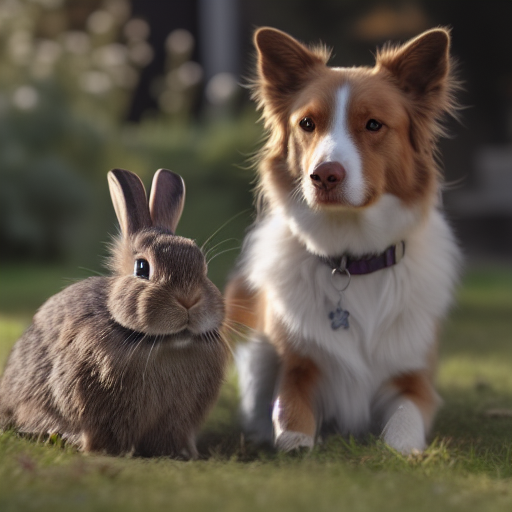

In [8]:
Image.fromarray(res[0])

In [9]:
words_dict = {
    '6': [[], [1, 2, 3, 4]],
    '11': [[], [1, 2, 3,4]],
    '8': [[], [1, 2, 3, 4,5,6]],
}

In [10]:
################################# background replace ############################################

# you can tune the hyper-paramters to obtain better results
# you can choose one from two sets of parameters
# =============================Hyper-paramter 1 (name = [6, 20])====================
# 
fusion_layers = {
    "encoder": [7, 8, 9, 10, 11, 12],
    "middle": True,
    "decoder": [13, 14, 15, 16, 17]
}
attn_layers = {
    "encoder": [4, 5, 6, 7, 8, 9, 10, 11, 12],
    "decoder": [13, 14, 15, 16, 17, 18, 19, 20],
}
t_combine = 200
self_replace_step = 0.8
# =============================Hyper-paramter 2 (name = 11) ====================
# fusion_layers = {
#     "encoder": [7, 8, 9, 10, 11],
#     "middle": True,
#     "decoder": [13, 14, 15, 16]
# }
# attn_layers = {
#     "encoder": [4, 5, 6, 7, 8, 9, 10, 11, 12],
#     "decoder": [13, 14, 15, 16, 17, 18, 19, 20],
# }
# t_combine = 200
# self_replace_step = 0.7 # or 0.6


masked_attn = True
init_rand = True # It is advisable to set init_rand to True, allowing multiple samples to choose the preferred result.
RATIO = 1
# ============================  back replace  ==================================
edit_prompts = {
    6: "A happy corgi running on the grass",
    8:"A cute corgi sitting on the snow",
    11:"A teddy bear is surfing on the sea",
}
name = 6


out_dir = os.path.join('results', 'ours-back')
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    with precision_scope(device.type):
        with model.ema_scope():

            name = str(name)
            img_path = os.path.join(root_dir, 'img_dir/%s.png' % name)
            tgt_image = repeat(
                load_img(img_path, 512, 512).cuda(), '1 ... -> b ...', b=1)
            prompt = prompts_dict[name]
            edit_prompt = edit_prompts[int(name)]
            print(prompt)
            print(edit_prompt)
            tgt_mask = 1 - get_mask_dilate(os.path.join(root_dir, 'masks/%s.png' % name))
            # define model_kwargs

            model_kwargs = {}
            model_kwargs['fusion_layers'] = fusion_layers
            model_kwargs["t_combine"] = t_combine
            model_kwargs["tgt_mask"] = tgt_mask
            model_kwargs["ref_mask"] = None
            model_kwargs["attn_mask"] = {
                'attn_mask': tgt_mask.clone(),
                'words': words_dict[name]
            } if masked_attn else None


            model_kwargs["attn_layers"] = attn_layers
            model_kwargs["self_replace_step"] = self_replace_step

            # get text conditions
            uc = model.get_learned_conditioning([""])
            src_cond = model.get_learned_conditioning([prompt])
            tgt_cond = model.get_learned_conditioning([edit_prompt])

            # get noisy images
            t_enc = int(DDIM_STEPS * RATIO)
            ref_latent = model.get_first_stage_encoding(
                model.encode_first_stage(tgt_image))
            ref_latents = sampler.ddim_loop(ref_latent, src_cond, t_enc)

            def corrector_fn(x, index):
                if index / DDIM_STEPS > model_kwargs['self_replace_step']:
                    x = x * tgt_mask + (1 - tgt_mask) * ref_latents[index]
                return x

            # sampling
            num_samples = 20 if init_rand else 1

            for ii in range(1):
                if init_rand:
#                     init_latent = torch.randn(ref_latents[-1].shape).cuda()
#                     init_latent = torch.load('data/rand_inits/%d.pt' % ii).cuda()
                    init_latent = torch.load('data/samples_in_paper/%s.pt' % name).cuda() 
                else:
                    init_latent = ref_latents[-1].clone()
                recover_latent = sampler.ddim_replace_object(init_latent, ref_latents, src_cond, tgt_cond, t_enc,
                                                             unconditional_guidance_scale=7.5,
                                                             unconditional_conditioning=uc,
                                                             corrector_fn=corrector_fn,
                                                             model_kwargs=model_kwargs)

                res = latent_to_image(model, recover_latent)
                Image.fromarray(res[0]).save(
                    out_dir + '/%s_%d.png' % (name, ii))
                print('Results are saved to %s' % out_dir)

A happy corgi running on the beach
A happy corgi running on the grass


Encoding image: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.95it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.05it/s]


Results are saved to results/ours-back


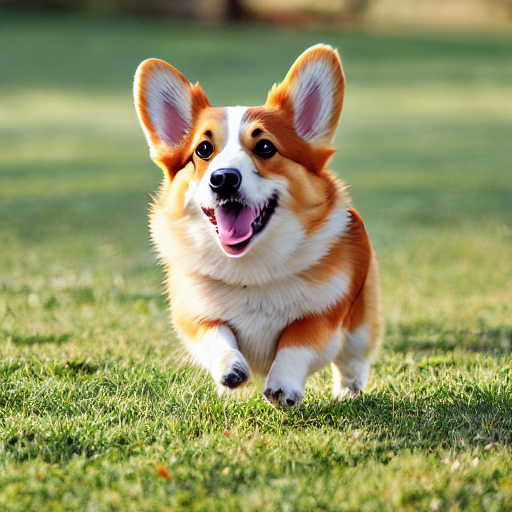

In [11]:
Image.fromarray(res[0])